# DFT + GWBSE Energy Calculation Using CH4

## Introduction

This tutorial explains how to perform calculation to predict electronic excitation using the **GWBSE** method. See [the GW Compendium: A Practical Guide to Theoretical Photoemission Spectroscopy](https://doi.org/10.3389/fchem.2019.00377), for an excellent introduction to the method.

## Requirements
* You will need to install **VOTCA** using the instructions described [here](https://github.com/votca/votca/blob/master/share/doc/INSTALL.rst)
* Once the installation is completed you need to activate the VOTCA enviroment by running the `VOTCARC.bash` script that has been installed at the bin subfolder for the path that you have provided for the installation step above

## Interacting with the XTP command line interface
To run a DFT-GWBSE calculation we will use the [xtp_tools](https://votca.github.io/xtp_tools.html) calculator. Run the following command to view the help message of `xtp_tools`:

In [1]:
!xtp_tools --help

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_tools, version 2021-dev gitid: 7b9f6d0 (compiled Jan 12 2021, 16:30:57)
votca_csg, version 2021-dev gitid: 7b9f6d0 (compiled Jan 12 2021, 16:30:41)
votca_tools, version 2021-dev gitid: 7b9f6d0 (compiled Jan 12 2021, 16:30:38)

Runs excitation/charge transport tools



Allowed options:
  -h [ --help ]                 display this help and exit
  --verbose                     be loud and noisy
  --verbose1                    be very loud and noisy
  -v [ --verbose2 ]             be extremly loud and noisy
  -o [ --options ] arg          calculator options
  -t [ --nthreads ] arg (=1)    number of threads to create

Tools:
  -e [ --execute ] arg        name of the tool to run
  -l [ --list ]               Lists all available tools
  -d [ --description ] arg    Short description of a tool
  -n [ --name ] arg           Name of the job to run



### Note
> * In Jupyter the `!` symbol means: *run the following command as a standard unix command*
> * In Jupyter the command `%env` set an environmental variable

## Running a calculation with the default options
To run a DFT-GWBSE calculation we just need to provide the path to the file in XYZ with the molecular coordinates. Check the [dftgwbse defaults](https://votca.github.io/dftgwbse.html) for further information.

In [2]:
!xtp_tools -n methane -t 2 -e dftgwbse > dftgwbse.log

The previous command will run the DFT-GWBSE calculation using the aforementioned defaults and the results are store in the *Current Work Directory* in a file named `methane_summary.xml`.

## Running a calculation using your own input file
Let create a folder to store the input `options` for XTP and copy the defaults in there

In [3]:
!mkdir -p OPTIONFILES
!cp $VOTCASHARE/xtp/xml/dftgwbse.xml OPTIONFILES

You should have a *XML* file with the DFTWGSE options that looks like

In [4]:
!head -n 10 OPTIONFILES/dftgwbse.xml

<?xml version="1.0"?>
<options>
  <!-- xtp_tools -e dftgwbse options.xml -->
  <dftgwbse help="Compute electronic excitations using GW-BSE">
    <optimize help="Perform a molecular geometry optimization" default="false" choices="bool"/>
    <basisset help="Basis set for MOs" default="def2-tzvp"/>
    <auxbasisset help="Auxiliary basis set for RI" default="aux-def2-tzvp"/>
    <functional help="Functional name(s) according to LIBXC" default="XC_HYB_GGA_XC_PBEH"/>
    <dftpackage>
      <package>


We will use the folling python snippet to change the `basisset` and the `auxbasisset`,

In [5]:
from xml_editor import edit_calculator
edit_calculator("dftgwbse", "basisset", "ubecppol")
edit_calculator("dftgwbse", "auxbasisset", "aux-ubecppol")

The option 'basisset' on file 'OPTIONFILES/dftgwbse.xml' has been set to 'ubecppol'
The option 'auxbasisset' on file 'OPTIONFILES/dftgwbse.xml' has been set to 'aux-ubecppol'


Now you can run the calculation using the `-o` command line argument, as follows

In [6]:
!xtp_tools -n methane -t 2 -e dftgwbse -o OPTIONFILES/dftgwbse.xml > dftgwbse.log

### Note
Alternatively you could have create an empty `dftgwbse.xml` file and add the `basisset` and the `auxbasisset` by hand, as follows,

```xml
<options>
  
  <dftgwbse help="Compute electronic excitations using GW-BSE">
    <basisset>ubecppol</basisset>
    <auxbasisset>aux-ubecppol</auxbasisset>
  </dftgwbse>

</options>
```

XTP will automatically compare the default values with the user-provided and overwrites the defaults with the user input. Also, If I given property does not have a default value you can provide one using the XML file described above.

## Partial Charges
We can compute now the partial charges using the `CHELPG` method by default. For more information see the [partialcharges documentation](https://votca.github.io/partialcharges.html). Once again, we only need to provide the name of the system to compute, which in our case is `methane`.

In [7]:
!xtp_tools -n methane -e partialcharges

Registered partialcharges==================================================
========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_tools, version 2021-dev gitid: 7b9f6d0 (compiled Jan 12 2021, 16:30:57)
votca_csg, version 2021-dev gitid: 7b9f6d0 (compiled Jan 12 2021, 16:30:41)
votca_tools, version 2021-dev gitid: 7b9f6d0 (compiled Jan 12 2021, 16:30:38)

Initializing tool
... partialcharges Evaluating tool
... partialcharges  Using 1 threads
... ...  Loading QM data from methane.orb
... ... ===== Running on 1 threads ===== 
... ... 2021-1-12 16:39:11 Calculated Densities at Numerical Grid, Number of electrons is 4.36691e-08
... ... 2021-1-12 16:39:11 Calculating ESP at CHELPG grid points
... ... 2021-1-12 16:39:14 Netcharge constrained to 0
... ...  Sum of fitted charges: -2.17812e-14
... ...  RMSE of fit:  0.0027395
... ...  RRMSE of fit: 0.130702
... ... El Dipole from fitted charges [e*bohr]:
		 dx = -0.7002 dy = +0.5171 d

## Spectrum Calculation
Finally, lets compute a convolution of the singlet spectrum using a gaussian function. For doing so, we will modify the default values for the [spectrum calculator](https://votca.github.io/spectrum.html) to compute the spectrum between 9 and 25 eV, using 1000 points in that energy range. We will first grap a copy of [spectrum calculator](https://votca.github.io/spectrum.html) and the modify its values as follows,

In [8]:
!cp $VOTCASHARE/xtp/xml/spectrum.xml OPTIONFILES
edit_calculator("spectrum", "lower", "9")
edit_calculator("spectrum", "upper", "25")
edit_calculator("spectrum", "points", "1000")

The option 'lower' on file 'OPTIONFILES/spectrum.xml' has been set to '9'
The option 'upper' on file 'OPTIONFILES/spectrum.xml' has been set to '25'
The option 'points' on file 'OPTIONFILES/spectrum.xml' has been set to '1000'


Finally, we can invoke the calculator

In [9]:
!xtp_tools -n methane -e spectrum -o OPTIONFILES/spectrum.xml

Registered spectrum==================================================
========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_tools, version 2021-dev gitid: 7b9f6d0 (compiled Jan 12 2021, 16:30:57)
votca_csg, version 2021-dev gitid: 7b9f6d0 (compiled Jan 12 2021, 16:30:41)
votca_tools, version 2021-dev gitid: 7b9f6d0 (compiled Jan 12 2021, 16:30:38)

Initializing tool
... spectrum Evaluating tool
... spectrum  Using 1 threads
... ... Calculating absorption spectrum plot methane.orb
... ...  Loading QM data from methane.orb
... ...  Considering 5 excitation with max energy 6.9598 eV / min wave length 179.923 nm
... ...  Spectrum in energy range from  9 to 25 eV and with broadening of FWHM 0.2 eV written to file  methane_spectrum.dat

The results are stored in the `methane_spectrum.dat` file.

## (Optional) Plot the spectrum

We will use [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/) and [pandas](https://pandas.pydata.org/) libraries to plot the spectrum. You can install it using [pip](https://pip.pypa.io/en/stable/) like

In [10]:
!pip install seaborn --user

[]

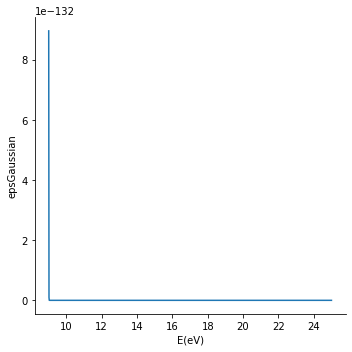

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
columns = ["E(eV)", "epsGaussian","IM(eps)Gaussian",  "epsLorentz",  "Im(esp)Lorentz"] 
df = pd.read_table("methane_spectrum.dat", comment="#", sep='\s+',names=columns) 
sns.relplot(x="E(eV)", y="epsGaussian", ci=None, kind="line", data=df) 
plt.plot()